# Optimising Preprocessing Parameters

In [2]:
%matplotlib inline

import os
import random

from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import seaborn as sns

import numpy as np
import pandas as pd
import cv2
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

In [3]:
# get the list of filenames in a given directory

camera_view = 'KL11-E1DC'

availible_ids = [int(file.split('.')[0])
                 for file in os.listdir(f"./data/real/{camera_view}/") 
                 if file.endswith(".png")]

print(f'number of unique images: {len(availible_ids)}')
print(f'number of pairs: {len(availible_ids)*len(availible_ids)-1}')

number of unique images: 109
number of pairs: 11880


Some functions that are used throughout this notebook. Including functions that plot a range of parameters on a grid of graphs and also returns a value for the variance of the Laplacian/Fourier transforms.

In [11]:
# some helper functions
def load_img(img_id):
    return cv2.imread(f'./data/{camera_view}/{img_id}.png', 
                      cv2.IMREAD_GRAYSCALE)


def plot_two(img_a, name_a, img_b, name_b):
    plt.figure(1, figsize=(13,13))
    
    plt.subplot(121)
    plt.title(name_a)
    plt.imshow(img_a)

    plt.subplot(122)
    plt.title(name_b)
    plt.imshow(img_b)
    
    plt.show()
    
def plot_hist(img_a, name_a, img_b, name_b, p, x, color):
    plt.figure(1, figsize=(6,3))
    
    plt.subplot(121)
    plt.title(name_a)
    plt.imshow(img_a)

    plt.subplot(122)
    plt.xlim([0,256])
    plt.plot(x, p, 'g', linewidth=2)
    plt.title(name_b)
    plt.plot(img_b,color)
    
    plt.show()


def plot_three(imgs, names):
    # there is probably a better way...
    plt.figure(1, figsize=(17,10))
    
    for i in range(3):
        
        plt.subplot(131 + i)
        plt.title(names[i])
        plt.imshow(imgs[i])
    
    plt.show()

    

def map_2_params_Laplace(img, _operation, x_params, x_param_name, y_params, y_param_name):
    """ 
    Makes a 2D grid of plots by applying the function '_operation' to 'img'
    accross the parameter space defined in the other arguments
    """
    # set up axes
    fig, axs = plt.subplots(nrows=len(x_params), 
                            ncols=len(y_params),
                            sharex='col', sharey='row',
                            figsize=(15,15.4))
    
    #Compute the variance of the Laplacian
    

    # loop through axes and make each plot
    for i, x_param in enumerate(x_params):        
        for j, y_param in enumerate(y_params):
            
            # plot image with these parameters
            axs[j,i].imshow(_operation(img, x_param, y_param))
            #axs[j,i].imshow(cv2.Canny(_operation(img, x_param, y_param), 80, 140, apertureSize=3, L2gradient=True))
            Laplace = cv2.Laplacian(_operation(img, x_param, y_param), cv2.CV_64F).var()
            
            # decide whether or not to label axes
            if j == 0:
                axs[j,i].set_title(f'{x_param_name} = {x_param:.2f}')
            if i == 0:
                axs[j,i].set_ylabel((f'{y_param_name} = {y_param:.2f}'), fontsize=12)
            
            #Show the variance of the Laplacian
            axs[j,i].set_xlabel((f'Variance = {Laplace:.2f}'))
            
            # tick hiding
            axs[j,i].tick_params(
                bottom=False,
                left=False,
                labelbottom=False,
                labelleft=False)
    
    # title
    fig.text(0.5, 0.92, f'Applying {_operation.__name__}()', ha='center', va='center', fontsize=14)
    
    # formatting
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    
def prelim_plot_blur(imgs, imagenames):
    N = len(imgs)
    ncols = 3
    nrows = int((N+2)/3)
    k=0
    
    fig, axs = plt.subplots(nrows, 
                            ncols,
                            sharex='col', sharey='row',
                            figsize=(15,15.4))
    
    for i in range(0,ncols):        
        for j in range(0,nrows):
            
            # plot image with these parameters
            axs[j,i].imshow(imgs[k])
            #axs[j,i].imshow(cv2.Canny(_operation(img, x_param, y_param), 80, 140, apertureSize=3, L2gradient=True))
            Laplace = cv2.Laplacian(imgs[k], cv2.CV_64F).var()
            
            # decide whether or not to label axes
            
            #Show the variance of the Laplacian
            axs[j,i].set_xlabel((f'Variance = {Laplace:.2f}'))
            axs[j,i].set_title(imagenames[k])
            
            # tick hiding
            axs[j,i].tick_params(
                bottom=False,
                left=False,
                labelbottom=False,
                labelleft=False)
            if k == N-1:
                return
            else:
                k+=1

def blur_params(imgs):
    N = len(imgs)
    blur_param = []
    for i in range(0,N):        
        blur_param.append(cv2.Laplacian(imgs[i], cv2.CV_64F).var())
    return blur_param

Widely used function in openCV that corrects the contrast of images.

In [5]:
def correct_contrast(img, clip_limit=3, tile_size=7):
    
    # create the object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, 
                            tileGridSize=(tile_size, tile_size))
    
    # apply equalisation
    return clahe.apply(img)

Choose a predetermined image. A low contrast image is used for the first part of the notebook but later random images are used to demonstrate its versaltility so far.

In [6]:
# clear
img_clear = 92182

# low contrast
img_lcontrast = 89065

# plasma blurry
img_blur = 89463

# plasma noisy
img_noise = 90469

# another one
img_predict = 90114

imagenumbers = [img_clear, img_lcontrast, img_blur, img_noise, img_predict]
imagenames = ['img_clear', 'img_lcontrast', 'img_blur', 'img_noise', 'img_predict']
images = []
for image in imagenumbers:
    images.append(cv2.imread(f'./data/real/KL11-E1DC/{image}.png', cv2.IMREAD_GRAYSCALE))

In [7]:
# downsample
downsampled_clear = cv2.pyrDown(img_clear)
downsampled_lcontrast = cv2.pyrDown(img_lcontrast)
downsampled_blur = cv2.pyrDown(img_blur)
downsampled_noise = cv2.pyrDown(img_noise)
downsampled_predict = cv2.pyrDown(img_predict)

imgs = [downsampled_clear, downsampled_lcontrast, downsampled_blur, downsampled_noise, downsampled_predict]

# Preliminary Tests

## Quantifying Blur

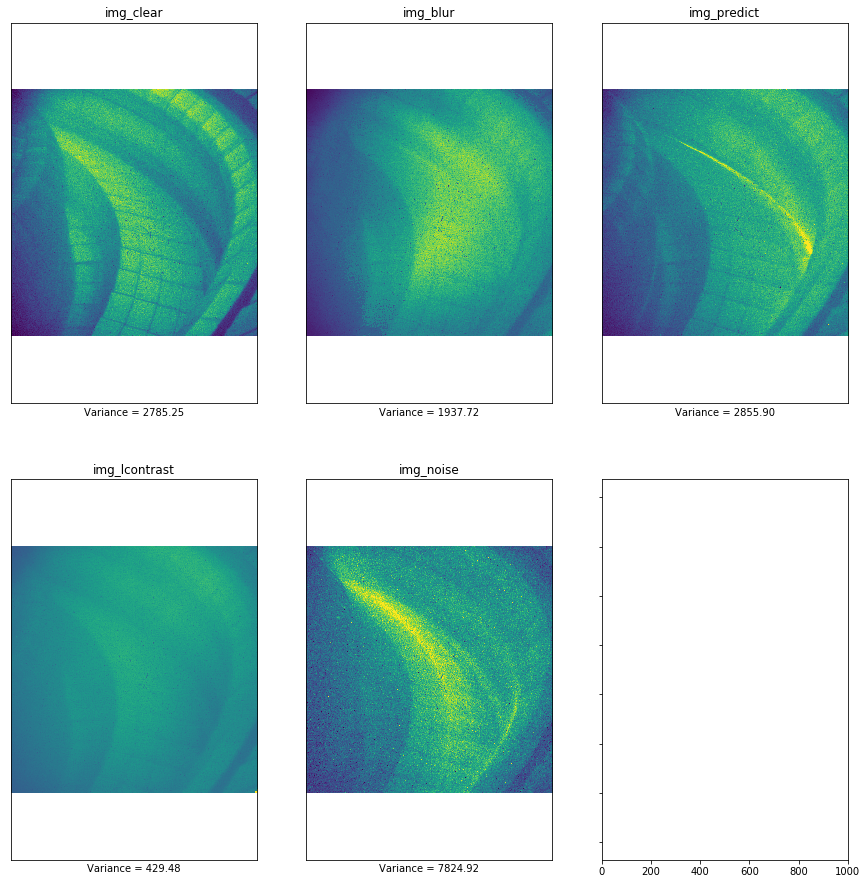

In [12]:
prelim_plot_blur(images, imagenames)
blur_param = blur_params(images)

## Quantifying Noise

In [18]:
criticalValue = 0.4
noise_param = []
k = 0
for im in images:
    isNoise = 0
    i = 0
    j = 0
    for row in im:
        for col in row:
            if(j+1 == len(row)):
                break
            elif(np.abs(im[i,j]) == 0 or np.abs(im[i,j+1]) == 0):
                pass
            elif(np.abs(1 - int(im[i,j])/(int(im[i,j+1]))) > criticalValue):
                isNoise += 1
            j +=1
        i +=1
    print(imagenames[k])
    noise_param.append(isNoise)
    k += 1
    print('Noise parameter = ' + str(isNoise))
print(noise_param)

img_clear
Noise parameter = 30
img_lcontrast
Noise parameter = 0
img_blur
Noise parameter = 7
img_noise
Noise parameter = 115
img_predict
Noise parameter = 24
[30, 0, 7, 115, 24]


## Quantifying Contrast

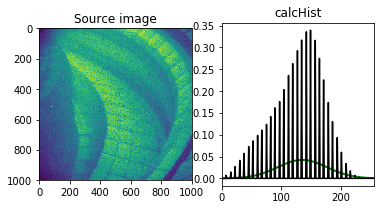

variance = 41.3046981572


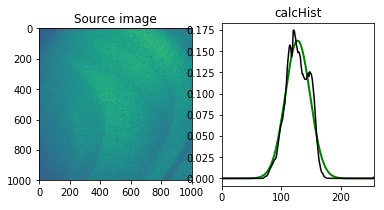

variance = 20.857391664


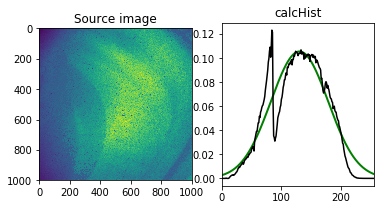

variance = 48.1655615222


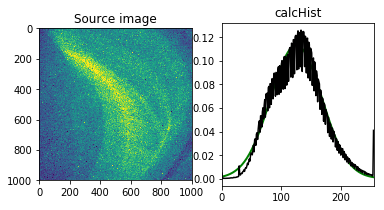

variance = 42.9485416985


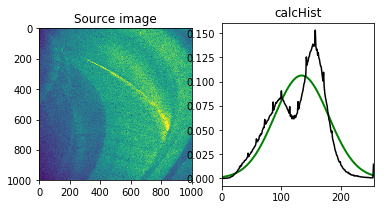

variance = 45.4152909328
[41.304698157203525, 20.857391663975072, 48.165561522247167, 42.948541698492441, 45.415290932797802]
1.0
0.19482673615982538
0.22592518989928892
0.22289356542958103
0.2513143415756925


In [10]:
def get_Histogram(image):
    bgr_planes = cv2.split(image)

    histSize = 256
    histRange = (0, 256) # the upper boundary is exclusive
    accumulate = False

    b_hist = cv2.calcHist(bgr_planes, [0], None, [histSize], histRange, accumulate=accumulate)
    g_hist = cv2.calcHist(bgr_planes, [1], None, [histSize], histRange, accumulate=accumulate)
    r_hist = cv2.calcHist(bgr_planes, [2], None, [histSize], histRange, accumulate=accumulate)

    hist_w = 512
    hist_h = 400

    bin_w = int(hist_w/histSize)
    histImage = np.zeros((hist_h, hist_w, 3), dtype=np.uint8)

    cv2.normalize(b_hist, b_hist, alpha=0, beta=hist_h, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(g_hist, g_hist, alpha=0, beta=hist_h, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(r_hist, r_hist, alpha=0, beta=hist_h, norm_type=cv2.NORM_MINMAX)

    for i in range(1, histSize):
        cv2.line(histImage, ( bin_w*(i-1), hist_h - int(b_hist[i-1]) ),
                ( bin_w*(i), hist_h - int(b_hist[i]) ),
                ( 255, 0, 0), thickness=2)
        cv2.line(histImage, ( bin_w*(i-1), hist_h - int(g_hist[i-1]) ),
                ( bin_w*(i), hist_h - int(g_hist[i]) ),
                ( 0, 255, 0), thickness=2)
        cv2.line(histImage, ( bin_w*(i-1), hist_h - int(r_hist[i-1]) ),
                ( bin_w*(i), hist_h - int(r_hist[i]) ),
                ( 0, 0, 255), thickness=2)
    return histImage

def draw_image_histogram(image, channels):
    hist = cv2.calcHist([image], channels, None, [256], [0, 256])
    hist = cv2.normalize(hist, None)
    return hist

def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.0*sigma**2))

contrast_param = []
hist = []
for img in images:
    histImage = draw_image_histogram(img, [0])
    hist.append(histImage)
    #histImage = preprocessing.normalize(histImage)
    bin_centres = np.arange(0,len(histImage))
    histImage = np.array([i[0] for i in histImage])
    mean = sum(bin_centres * histImage)
    sigma = sum(bin_centres * (histImage - mean)**2)
    p0 = [1.0, 126, 50]

    coeff, var_matrix = curve_fit(gauss, bin_centres, histImage, p0=p0)

# Get the fitted curve
    hist_fit = gauss(bin_centres, coeff[0], coeff[1], coeff[2])
    x = range(0,256,1)
    contrast_param.append(coeff[2])
    
    plot_hist(img,'Source image', histImage, 'calcHist', hist_fit, x, color = 'k')
    print('variance = ' + str(coeff[2]))

print(contrast_param)
for i in range(0,len(images)):
    print(cv2.compareHist(hist[0], hist[i], method=cv2.HISTCMP_CORREL))

## Clustering

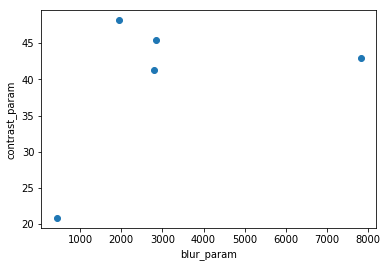

In [16]:
plt.plot(blur_param, contrast_param, 'o')
plt.xlabel('blur_param')
plt.ylabel('contrast_param')
plt.show()

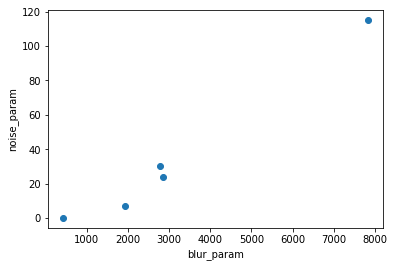

In [20]:
plt.plot(blur_param, noise_param, 'o')
plt.xlabel('blur_param')
plt.ylabel('noise_param')
plt.show()

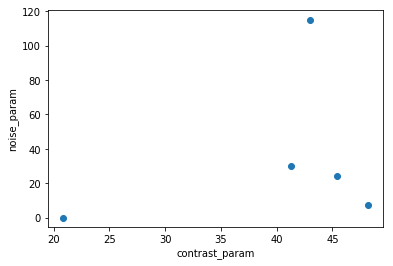

In [25]:
plt.plot(contrast_param, noise_param, 'o')
plt.ylabel('noise_param')
plt.xlabel('contrast_param')
plt.show()

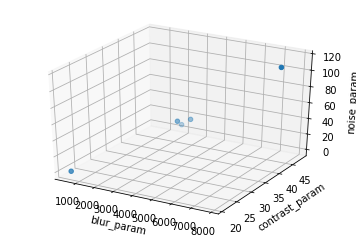

In [23]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(blur_param, contrast_param, noise_param, 'o')
ax.set_xlabel('blur_param')
ax.set_ylabel('contrast_param')
ax.set_zlabel('noise_param')
plt.show()

## Making Predictions

Manually making predictions on [blurry, noisy, low contrast]

In [27]:
labels = []
N = len(images)

for i in range(0,N):
    properties = [False, False, False]
    if(blur_param[i]<1500):
        properties[0] = True
    if(noise_param[i] > 80):
        properties[1] = True
    if(contrast_param[i] < 30):
        properties[2] = True
    labels.append(properties)
    
print(labels)
    

[[False, False, False], [True, False, True], [False, False, False], [False, True, False], [False, False, False]]


# Finding optimum parameters

## unsharp_mask

## equalizeHist 

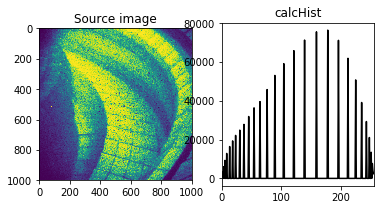

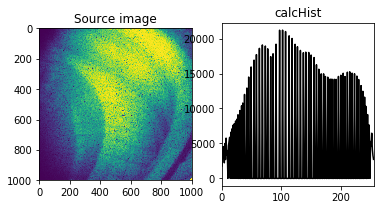

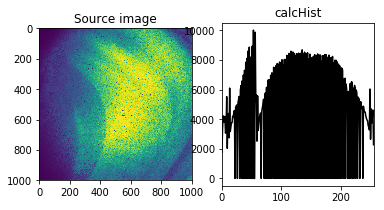

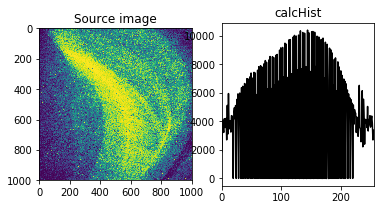

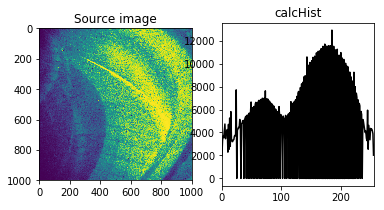

In [86]:
for img in images:
    eqimg = cv2.equalizeHist(img)
    hist = draw_image_histogram(img,[0])
    eqhist = draw_image_histogram(eqimg,[0])
    plot_hist(eqimg,'Source image',eqhist, 'calcHist', color = 'k')

## Optimising contrast correction

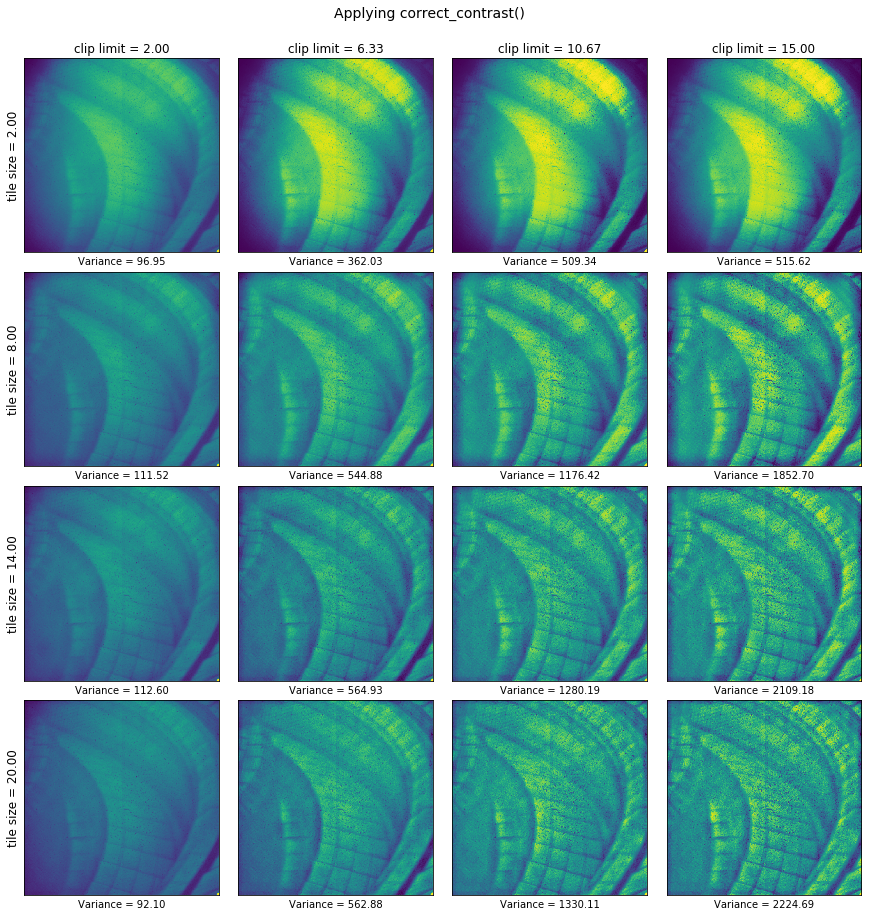

In [7]:
# set parameter space
clip_limits = np.linspace(2, 15, num=4)
tile_sizes = np.linspace(2, 20, num=4).astype(int)

# scan parameter space
map_2_params_Laplace(downsampled, correct_contrast, 
             clip_limits, 'clip limit', 
             tile_sizes, 'tile size')

In [ ]:
def find_optimum_contrast(img, clip_limits, tile_sizes):
    """ 
    Makes a 2D grid of plots by applying the function '_operation' to 'img'
    accross the parameter space defined in the other arguments
    """
    nrows = len(clip_limits)
    ncols = len(tile_sizes)
    k = 0
    optimumLap = 0
    optimumOrder = []
    optimumFunctions = []

    # loop through axes and make each plot
    for i in range(0, ncols):       
        for j in range(0, nrows):
            
            imgs, functions, ordering, Laplace = get_one_ordered_pp(img, operations, k)
            
            if(Laplace > optimumLap):
                optimumLap = Laplace
                optimumOrder = ordering
                optimumFunctions = functions
            k += 1

    return optimumLap, optimumFunctions, optimumOrder

## Optimising nlm

# Putting it all together